In [12]:
############## Imports ######################
import glob
import numpy as np;
import cv2;
from skimage.feature import hog
import os;
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pickle;

########### Parameters to tune ##############
pix_per_cell = 8
cell_per_block = 2
orient = 9

## Data Exploration

In [2]:
vehicle_images = glob.glob('./vehicles/**/*.png');
non_vehicle_images = glob.glob('./non-vehicles/**/*.png');
img = plt.imread(vehicle_images[np.random.randint(0,len(vehicle_images))]);

print('count of vehicle images : ',len(vehicle_images));
print('count of non vehicle images : ',len(non_vehicle_images));
print('Image Size : ',img.shape[:-1]);
print('Image Channel : ',img.shape[-1])

count of vehicle images :  8792
count of non vehicle images :  8968
Image Size :  (64, 64)
Image Channel :  3


## Data Visualization

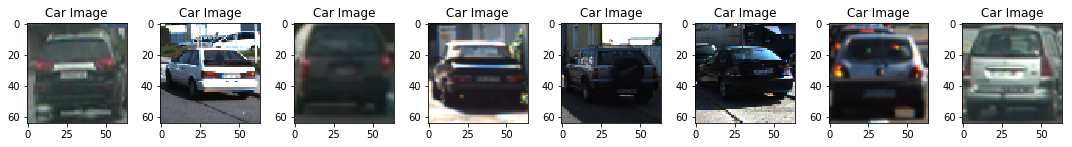

In [3]:
########### Visualizing Car Images ##############
row = 1
col = 8
plt.figure(figsize=(15,6))

for i in range(0,row*col):
    img = plt.imread(vehicle_images[np.random.randint(0,len(vehicle_images))]);
    plt.subplot(row,col,i+1);
    plt.title("Car Image");
    plt.imshow(img);
plt.tight_layout()
plt.show();

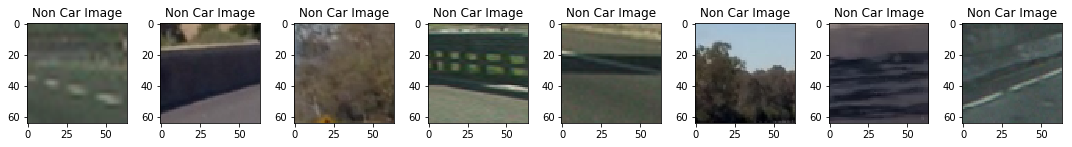

In [4]:
########### Visualizing Non Car Images #############
row = 1
col = 8
plt.figure(figsize=(15,6))

for i in range(0,row*col):
    img = plt.imread(non_vehicle_images[np.random.randint(0,len(non_vehicle_images))]);
    plt.subplot(row,col,i+1);
    plt.title("Non Car Image");
    plt.imshow(img);
plt.tight_layout()
plt.show();

## Histogram of Oriented Gradients (HOG)

Features size :  1764


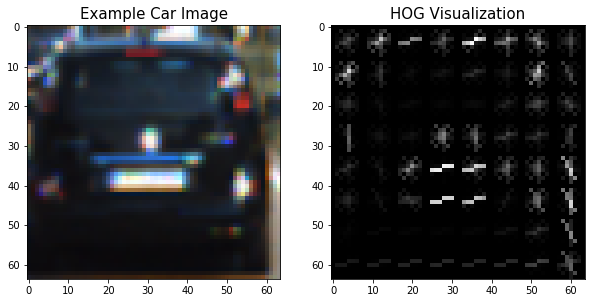

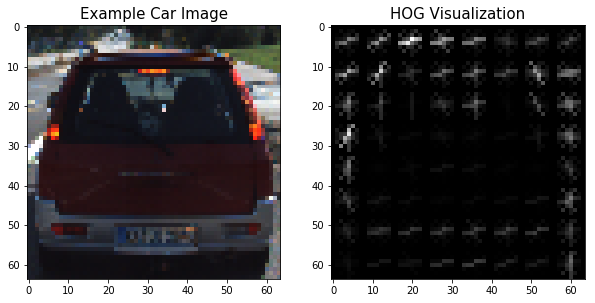

In [5]:
############## Methods for HOG feauture Extraction ##############

def extract_HOG_features(img,vis=False,feature_vector=True):
    
    if(vis==True):
        hog_features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=feature_vector,
                          block_norm="L2-Hys");
        return hog_features,hog_image;
    else:
        hog_features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=False, feature_vector=feature_vector,
                          block_norm="L2-Hys");
        return hog_features;

def test_hog_feture_extraction():
  
    for i in range(0,2):
        image = plt.imread(vehicle_images[np.random.randint(0,len(vehicle_images))]);
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        hog_feature,vis_img=extract_HOG_features(gray,vis=True);
        # Plot the examples
        fig = plt.figure(figsize=(10,10))
        plt.subplot(121)
        plt.imshow(image, cmap='gray')
        plt.title('Example Car Image',fontsize=15)
        plt.subplot(122)
        plt.imshow(vis_img, cmap='gray')
        plt.title('HOG Visualization',fontsize=15);
    print("Features size : ",hog_feature.shape[0]);

test_hog_feture_extraction();

In [16]:
#############################################################
#####            Features Extraction                    #####
#############################################################

def extract_features(file_names):
    features = [];
    for file_name in file_names:
        img=plt.imread(file_name);
        y_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,1]; # using Y-Channel of YUV Color space
        hog_features = extract_HOG_features(y_img,vis=False,feature_vector=True);
        features.append(hog_features);
        #features.append(extract_color_features(img));
    return features;

print("Features Extraction Started.....")
start_time = time.time();
#------------------------Start-----------------------------
vehicle_features = extract_features(vehicle_images);
non_vehicle_features = extract_features(non_vehicle_images)
#------------------------End-------------------------------
end_time = time.time();

print("Total time to extarct features :  ",end_time-start_time,"sec")

Features Extraction Started.....
Total time to extarct features :   162.42065238952637 sec


## Data Split

In [17]:
features = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64);
labels = np.hstack((np.ones(len(vehicle_features)),np.zeros(len(non_vehicle_features))));

#### Splitting training and test data ####
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.2)

In [18]:
print("Training Data Size : ",features_train.shape)
print("Testing Data Size : ",features_test.shape)

Training Data Size :  (14208, 1764)
Testing Data Size :  (3552, 1764)


## Classifier Training

In [19]:
print("Training Started.....")
start_time = time.time();
#------------------------Start-----------------------------
clf = SVC(kernel="linear")
clf.fit(features_train,labels_train);
#------------------------End-------------------------------
end_time = time.time();
total_time = end_time-start_time;
print("Total time to Train Classifier :  ",total_time,"sec")

Training Started.....
Total time to Train Classifier :   518.9744095802307 sec


## Saving model

In [20]:
with open('./model.pickle','wb') as model_file:
    pickle.dump(clf,model_file);
print("Model Saved..")

Model Saved..


## Classifier Test

In [21]:
test_score = clf.score(features_test,labels_test);
print("Test Accuracy of Classfier : ",test_score*100," %");


Test Accuracy of Classfier :  91.6666666667  %


In [ ]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    for box in bboxes:
        cv2.rectangle(draw_img,box[0],box[1],color,thick);
    return draw_img 

In [28]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, clf, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = extract_HOG_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = extract_HOG_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = extract_HOG_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            ######################################################################
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [29]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, clf, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

TypeError: extract_HOG_features() got an unexpected keyword argument 'feature_vec'